Imports

In [191]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
from pathlib import Path  
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import openai
from openai import OpenAI
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np
import os
import random

In [ ]:
nltk.download('vader_lexicon')


Creating the Dataset (or importing it)

In [208]:
client = openai.Client(api_key="Your API Key")
file_path = "./reviews_and_summaries.csv"
prompt_summaries = "Write a very brief summary the following book review. When reading the summary you have to be able to see the sentiment of the reviewer towards the book. The summary has to be done using formal writing, without the use of emojis. The reviewer might have included quotes or things that happen in the book: you should not include in the summary those, you just have to make sure in the summary is taken into account the sentiment evoked in this parts of the review. Emphasize in using positive words if the review is positive, neutral words if it is neutral and negative if it is negative. Do not use words that individually might express a different sentiment from the sentence (for example do not use terrifyingly good, as terrifyingly can be considered a negative word by itself)."     

def load_or_create_dataset(file_path, create_new = False, generate_summaries = True, prompt = prompt_summaries):
    
    if os.path.isfile(file_path) and not (create_new):
        
        # Load the dataset
        dataset = pd.read_csv(file_path)
        print("Dataset loaded from file.")
        
    else:
        
        #Web scrapping GoodReads to obtain the 30 top reviews of the 50 most popular books of 2023
        url = "https://www.goodreads.com/book/most_read?category=all&country=--&duration=y"
        info_reviews = web_scrapping(url)
        dataset = pd.DataFrame(info_reviews)
        
        #Dropping rows that contain NaNs values, sometimes might happend due to some web scrapping request failing
        dataset.dropna(inplace=True)
        
        Subsampling the reviews with the best rating in order to balance the classes a little bit more
        category_counts = dataset['Rating'].value_counts()
        filtered_rows = dataset[dataset['Rating'] == 5]
        rows_to_drop = filtered_rows.sample(n=category_counts.values[0]-category_counts.values[1], random_state=99)  # Adjust random_state as needed
        dataset = dataset.drop(rows_to_drop.index)
        
        if (generate_summaries):
            data = dataset["Reviews"].values
            summaries = ChatGPTPrompting(prompt,data)

            #We add to the dataset the 
            dataset["Review_Summaries"] = response_list

            #Due to token limitations, some of the summaries could not be performed
            dataset.dropna(inplace=True) 
        
        if (create_new):
            dataset.to_csv(filepath)  
            
    return dataset

In [200]:
def scrape_book_info(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        # Extracting description
        review_content = soup.find_all('section', class_='ReviewText__content')
        review_list = []
        review_card = soup.find_all('article', class_='ReviewCard')
        rating_list = []
        for card,review in zip(review_card,review_content):
            card = str(card)
            if "span aria-label" in card:
                card_soup = BeautifulSoup(card, 'html.parser')
                rating_span = card_soup.find('span', {'class': 'RatingStars__small'})
                rating_list.append(int(rating_span['aria-label'][7]))
                review_text = review.get_text(strip=True)
                review_list.append(review_text)
             
            
        return review_list,rating_list

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None, None


def web_scrapping(url):
    book_list = []

    url = "https://www.goodreads.com/book/most_read?category=all&country=--&duration=y"
    response_web = requests.get(url)

    if response_web.status_code == 200:
        soup = BeautifulSoup(response_web.text, 'html.parser')
        # Find the script tag containing the JSON data with book information
        book_links = soup.find_all('a', class_='bookTitle', itemprop='url')
        for link in book_links:
            book_name = link.find('span', itemprop='name').get_text(strip=True)
            book_href = link['href']
            reviews,rating = scrape_book_info("https://www.goodreads.com"+book_href)
            for rev,rat in zip(reviews,rating):
                book_list.append({
                    'Title': book_name,
                    'Reviews': rev,
                    'Rating': rat
                })
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    return book_list
    

    


In [188]:
def ChatGPTPrompting(prompt,data):
    response_list = []

    for text in data:
        try:
            if (len(text) > 10000):
                text = text[:10000]
            completion = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content":  prompt},     
                        {"role": "user", "content": text}
                    ]
                )
            response = completion.choices[0].message.content
            response_list.append(response)
        except:
            response_list.append(None)
            continue
            
    return response_list


Exploratory Data Analysis and Preprocessing of the Dataframe created only with the webscrapping

In [209]:
dataset_web = load_or_create_dataset(file_path, generate_summaries = False)

In [212]:
nans_per_column = dataset_web.isna().sum()
print(nans_per_column)
dataset_web.dropna(inplace=True)

Title      0
Reviews    0
Rating     0
dtype: int64


We can see that the dataset created is imbalanced, most of the reviews are very positive. 

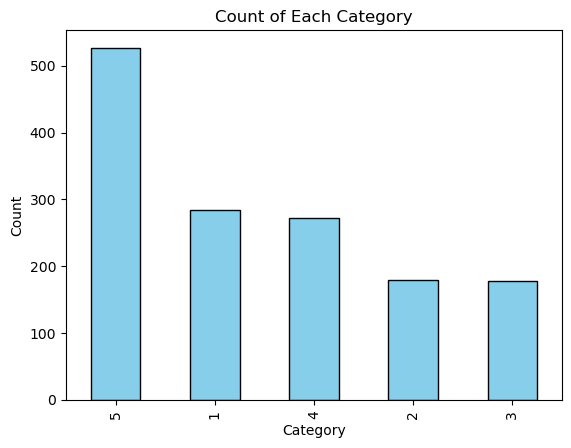

In [213]:
category_counts = dataset_web['Rating'].value_counts()

# Plot the counts
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')

# Show the plot
plt.show()

We undersample this number to the same as the ratings with 1. This is to make easier the evaluation of the results, as there is no training there wouldn't be overfitting.

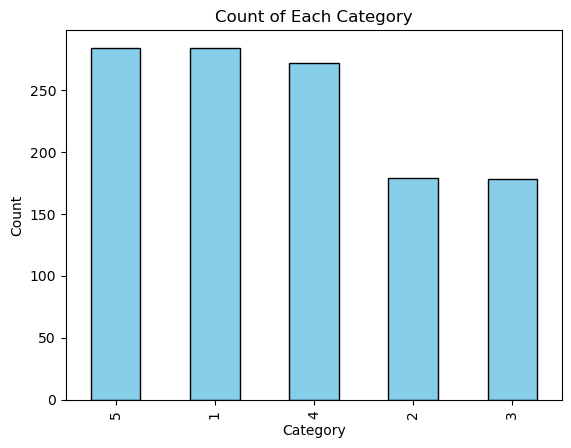

In [217]:
filtered_rows = dataset_web[dataset_web['Rating'] == 5]
rows_to_drop = filtered_rows.sample(n=category_counts.values[0]-category_counts.values[1], random_state=99)  # Adjust random_state as needed
dataset_web = dataset_web.drop(rows_to_drop.index)

category_counts = dataset_web['Rating'].value_counts()

# Plot the counts
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')

# Show the plot
plt.show()

Now it is less imbalanced.

### Tokenazing Functions

In [248]:
nlp = spacy.load('en_core_web_sm')

def text_preprocesser_VADER(text):
    doc = nlp(text)
    sentence_tokenized = []
    for sent in doc.sents:
        tokens = [token.lemma_ for token in sent if not token.is_stop]
        sentence_tokenized.append(tokens)
    return sentence_tokenized


def text_preprocesser(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return tokens


### VADER Sentiment Classifier

In [249]:
sia= SentimentIntensityAnalyzer()

def Vader_SC(text_tokens):
    SentimentResult = 0.0
    for sentence_tokens in text_tokens:
        vs = sia.polarity_scores((" ").join(sentence_tokens))
        SentimentResult += vs["compound"]
    score = SentimentResult/(len(text_tokens))
    if(score > 0.7):
        rating = 5
    elif(score > 0.2):
        rating = 4
    elif(score > -0.2):
        rating = 3
    elif(score > -0.7):
        rating = 2
    else:
        rating = 1
    return rating,score

In [250]:
def VADER_Classifier(data):
    
    preprocessed_text = []
    for review in data:
        preprocessed_text.append(text_preprocesser_VADER(review))
    results = [Vader_SC(text) for text in preprocessed_text]
    ratings = []
    scores = []
    for res in results:
        ratings.append(res[0])
        scores.append(res[1])
    return ratings,scores

In [224]:
def Accuracy_Score(predicted_rating,real_ratings):
    acc = sum(predicted_rating == real_ratings)/len(real_ratings)
    print(acc)


#### Results of VADER on the original Reviews

First of all we call at the complete dataset if not done yet, or we create it in case is needed. Summaries can be created on this step if the dataset called is not the complete, or after perforimg the classification on the original reviews.

In [251]:
prompt_summaries = "Write a very brief summary the following book review. When reading the summary you have to be able to see the sentiment of the reviewer towards the book. The summary has to be done using formal writing, without the use of emojis. The reviewer might have included quotes or things that happen in the book: you should not include in the summary those, you just have to make sure in the summary is taken into account the sentiment evoked in this parts of the review. Emphasize in using positive words if the review is positive, neutral words if it is neutral and negative if it is negative. Do not use words that individually might express a different sentiment from the sentence (for example do not use terrifyingly good, as terrifyingly can be considered a negative word by itself)."     

sentiment_analysis_df = load_or_create_dataset(file_path, generate_summaries = True, prompt = prompt_summaries)

Dataset loaded from file.


We first look at the accuracy, we can see that is not great

In [252]:
data = sentiment_analysis_df["Reviews"].values
predicted_ratings, score = VADER_Classifier(data)
real_ratings = sentiment_analysis_df["Rating"].values

Accuracy_Score(predicted_ratings,real_ratings)

0.2112321877619447


VADER predicts a continuos value between -1 and 1, so the accuracy does no tell that much about how well it predicts, since we have arbitrarely decided the threshold between sentiments. Correlations Coefficients will tell us better whether is giving to positive comments positive values and negative comments negative values.

In [253]:
# Spearman Rank Order Correlation Coefficient (SROCC)
srocc, _ = spearmanr(score, real_ratings)
print("Spearman Rank Order Correlation Coefficient (SROCC):", srocc)

# Pearson Linear Correlation Coefficient (PLCC)
plcc, _ = pearsonr(score, real_ratings)
print("Pearson Linear Correlation Coefficient (PLCC):", plcc)

Spearman Rank Order Correlation Coefficient (SROCC): 0.3329517444853972
Pearson Linear Correlation Coefficient (PLCC): 0.3100673392789148


We can see that the correlation value is positive, so it is giving a decent sentiment score to each review, but it could be way better. We will look also at the precision,recall and f1-score and also at the confussion matrix to see if its classifying mistakes make sense.

              precision    recall  f1-score   support

           1       0.57      0.01      0.03       284
           2       0.10      0.05      0.07       177
           3       0.15      0.60      0.24       177
           4       0.33      0.47      0.39       273
           5       0.31      0.02      0.03       282

    accuracy                           0.21      1193
   macro avg       0.29      0.23      0.15      1193
weighted avg       0.32      0.21      0.15      1193



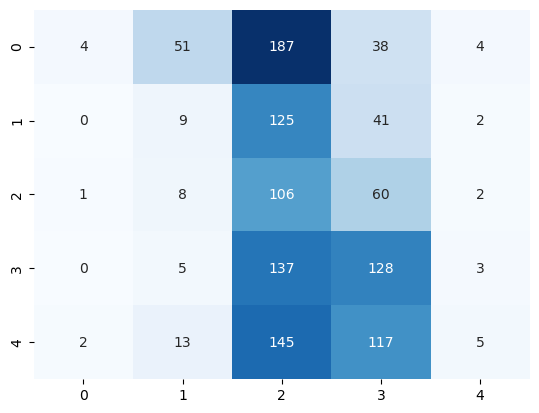

In [254]:
conf_matrix = confusion_matrix(real_ratings, predicted_ratings)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

report = classification_report(real_ratings, predicted_ratings)
print(report)

#### Results of Zero-shot SC with ChatGPT 3.5 on the original Reviews

In [259]:
prompt = "What is the sentiment of the following text? Please respond with 5 if it is very positive', 4 if it is a bit positive, 3 if it is neutral, 2 if it is a bit negative or 1 if it is very negative'. ONLY ANSWER WITH A NON DECIMAL NUMBER. If the review only provides the number of the rating, return the number. If it is decimal, return the truncated number. If there is no text to perform sentiment analysis, answer with ONLY a random integer between 1 and 5."    
data = sentiment_analysis_df["Reviews"].values
predicted_sentiment_gpt = ChatGPTPrompting(prompt,data)

real_ratings = sentiment_analysis_df_new["Rating"].values
predicted_ratings = []
for response in predicted_sentiment_gpt:
    try:
        predicted_ratings.append(int(float(response)))
    except:
        predicted_ratings.append(random.randrange(1, 6))
        continue
    
    

We first look at the accuracy

In [260]:
Accuracy_Score(predicted_ratings,real_ratings)

0.5523889354568315


Like before, we look at the correlation coefficients

In [264]:
srocc, _ = spearmanr(predicted_ratings, real_ratings)
print("Spearman Rank Order Correlation Coefficient (SROCC):", srocc)


# Pearson Linear Correlation Coefficient (PLCC)
plcc, _ = pearsonr(predicted_ratings, real_ratings)
print("Pearson Linear Correlation Coefficient (PLCC):", plcc)


Spearman Rank Order Correlation Coefficient (SROCC): 0.6646314041891861
Pearson Linear Correlation Coefficient (PLCC): 0.6527309439840877


Finally we look at the confusion matrix and the precision, recall and f1-score of each sentiment class

              precision    recall  f1-score   support

           1       0.62      0.79      0.70       284
           2       0.36      0.50      0.42       177
           3       0.35      0.15      0.21       177
           4       0.65      0.37      0.47       273
           5       0.61      0.77      0.68       282

    accuracy                           0.55      1193
   macro avg       0.52      0.52      0.50      1193
weighted avg       0.55      0.55      0.53      1193



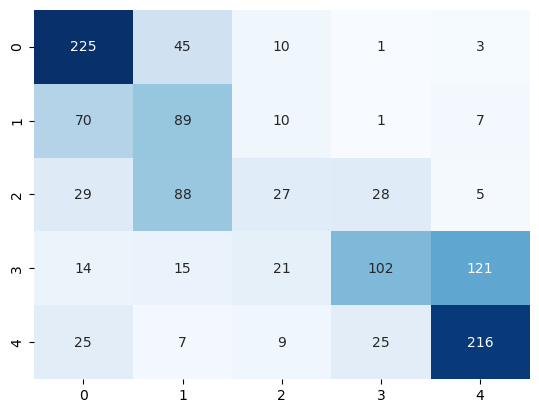

In [262]:
conf_matrix = confusion_matrix(real_ratings, predicted_ratings)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

report = classification_report(real_ratings, predicted_ratings)
print(report)

## Results of VADER on the summaries generated by prompt engineering

First the Accuracy

In [263]:
data = sentiment_analysis_df["Review_Summaries"].values
predicted_ratings, score = VADER_Classifier(data)
real_ratings = sentiment_analysis_df["Rating"].values

Accuracy_Score(predicted_ratings,real_ratings)

0.32774518021793797


Correlation coefficients

In [265]:
# Spearman Rank Order Correlation Coefficient (SROCC)
srocc, _ = spearmanr(score, real_ratings)
print("Spearman Rank Order Correlation Coefficient (SROCC):", srocc)

# Pearson Linear Correlation Coefficient (PLCC)
plcc, _ = pearsonr(score, real_ratings)
print("Pearson Linear Correlation Coefficient (PLCC):", plcc)

Spearman Rank Order Correlation Coefficient (SROCC): 0.6854320867151016
Pearson Linear Correlation Coefficient (PLCC): 0.6825062197060913


Finally we look at the confusion matrix and the precision, recall and f1-score of each sentiment class

              precision    recall  f1-score   support

           1       0.58      0.09      0.16       284
           2       0.25      0.36      0.29       177
           3       0.24      0.42      0.31       177
           4       0.37      0.65      0.47       273
           5       0.48      0.18      0.26       282

    accuracy                           0.33      1193
   macro avg       0.38      0.34      0.30      1193
weighted avg       0.41      0.33      0.30      1193



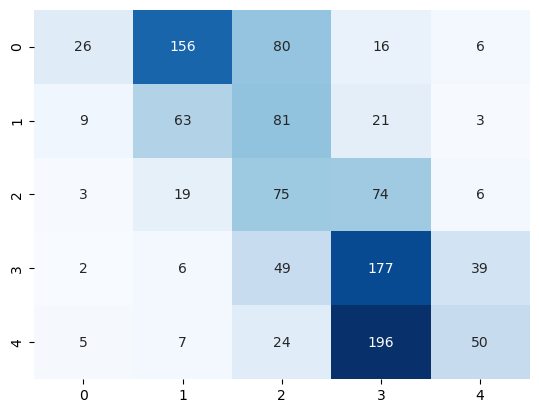

In [266]:
conf_matrix = confusion_matrix(real_ratings, predicted_ratings)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

report = classification_report(real_ratings, predicted_ratings)
print(report)

## Results of Zero-shot SC with ChatGPT 3.5 on the summaries generated by prompt engineering

In [267]:
prompt = "What is the sentiment of the following text? Please respond with 5 if it is very positive', 4 if it is a bit positive, 3 if it is neutral, 2 if it is a bit negative or 1 if it is very negative'. ONLY ANSWER WITH A NON DECIMAL NUMBER. If the review only provides the number of the rating, return the number. If it is decimal, return the truncated number. If there is no text to perform sentiment analysis, answer with ONLY a random integer between 1 and 5. ALWAYS ANSWER WITH AN INTEGER BETWEEN 1 AND 5, NEVER USE TEXT."     

data = sentiment_analysis_df["Review_Summaries"].values
predicted_sentiment_gpt = ChatGPTPrompting(prompt,data)

real_ratings = sentiment_analysis_df_new["Rating"].values
predicted_ratings = []
for response in predicted_sentiment_gpt:
    try:
        predicted_ratings.append(int(float(response)))
    except:
        predicted_ratings.append(random.randrange(1, 6))
        continue

Accuracy

In [268]:
Accuracy_Score(predicted_ratings,real_ratings)

0.5699916177703269


Correlation Coefficients

In [269]:
srocc, _ = spearmanr(predicted_ratings, real_ratings)
print("Spearman Rank Order Correlation Coefficient (SROCC):", srocc)


# Pearson Linear Correlation Coefficient (PLCC)
plcc, _ = pearsonr(predicted_ratings, real_ratings)
print("Pearson Linear Correlation Coefficient (PLCC):", plcc)


Spearman Rank Order Correlation Coefficient (SROCC): 0.799787761450642
Pearson Linear Correlation Coefficient (PLCC): 0.808000008440343


Finally we look at the confusion matrix and the precision, recall and f1-score of each sentiment class

              precision    recall  f1-score   support

           1       0.60      0.87      0.71       284
           2       0.37      0.32      0.34       177
           3       0.66      0.27      0.38       177
           4       0.61      0.34      0.44       273
           5       0.59      0.83      0.69       282

    accuracy                           0.57      1193
   macro avg       0.56      0.53      0.51      1193
weighted avg       0.57      0.57      0.54      1193



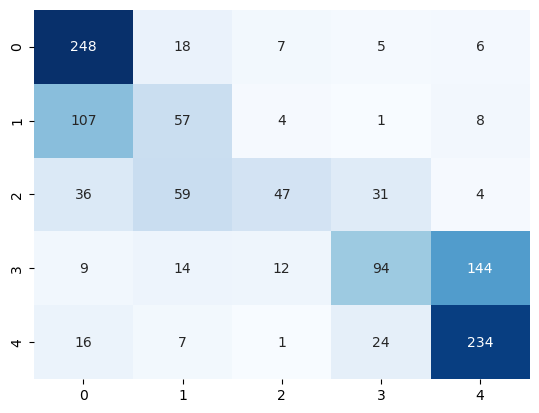

In [270]:
conf_matrix = confusion_matrix(real_ratings, predicted_ratings)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

report = classification_report(real_ratings, predicted_ratings)
print(report)

### Evaluating the summaries created and the results obtained through them

#### Analising the lengths of the summaries and their impact

In [271]:
evaluation_dataset = sentiment_analysis_df.copy()
evaluation_dataset["Prediction_VADER"] = ratings
evaluation_dataset["Prediction_GPT"] = ratings_summaries
evaluation_dataset.drop('Unnamed: 0', axis=1,inplace=True)


We first look at the distribution of the lengths of the summaries generated

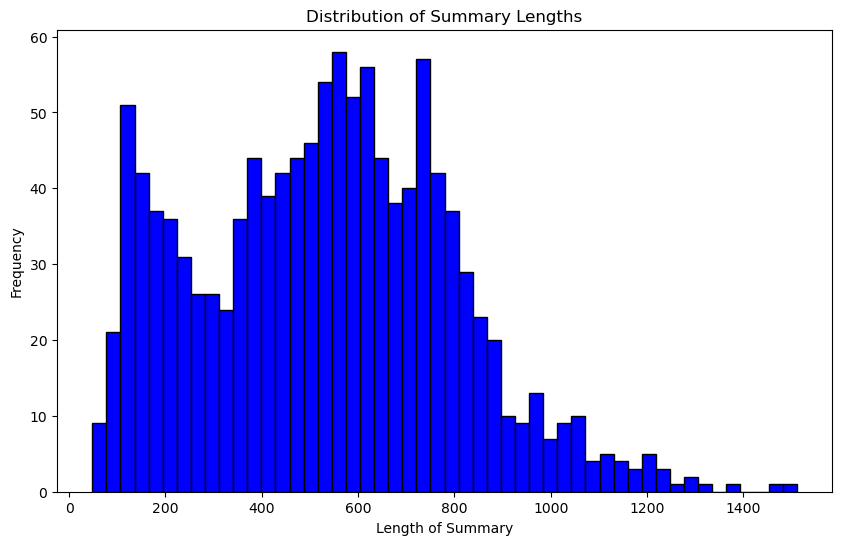

In [272]:

evaluation_dataset["Length_Summary"] = evaluation_dataset['Review_Summaries'].str.len()

# Plotting
plt.figure(figsize=(10, 6))  # You can adjust the size of the figure
plt.hist(evaluation_dataset["Length_Summary"], bins=50, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')

# Show the plot
plt.show()

We can see that most of the summaries are no longer than 800 words. Now it is time to look if it affects the length of the summary on the performance of our Sentiment Classifiers. Firts we compute how much the classification deviates from the actual rating given by that review.

In [273]:
evaluation_dataset["Deviation_Correct_VADER"] = abs(evaluation_dataset["Rating"] - evaluation_dataset["Prediction_VADER"])
evaluation_dataset["Deviation_Correct_GPT"] = abs(evaluation_dataset["Rating"] - evaluation_dataset["Prediction_GPT"])


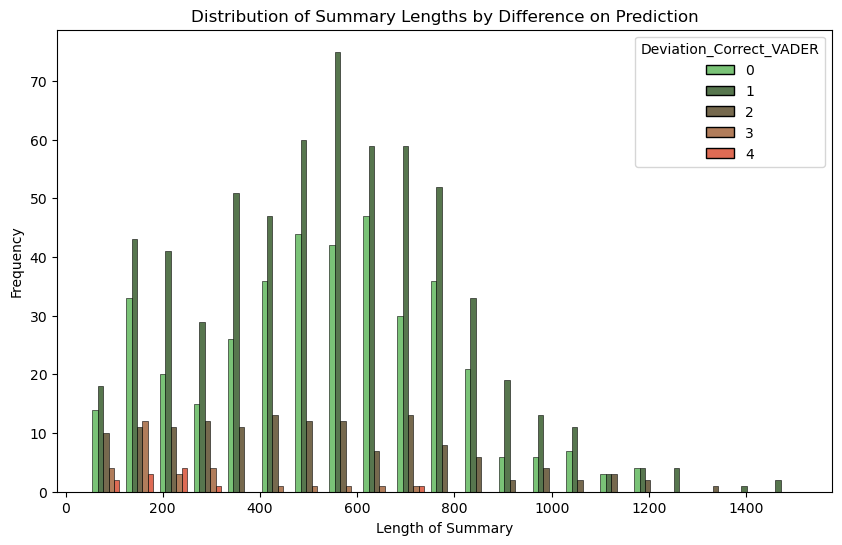

In [274]:
custom_palette = ["#4daf4a", "#1f4812", '#483712', '#975124', '#d33a1b']
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=evaluation_dataset, x='Length_Summary', hue='Deviation_Correct_VADER', multiple='dodge', shrink=0.8, palette=custom_palette)
plt.title('Distribution of Summary Lengths by Difference on Prediction')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In the case of the VADER sentiment classifier, we can see that it mostly deviates by 1 (most of the very positive are classified as positive and the very negative as negative, as we have seen in the confusion matrix). For the very long summaries and the very short summaries it seems to perform worse.

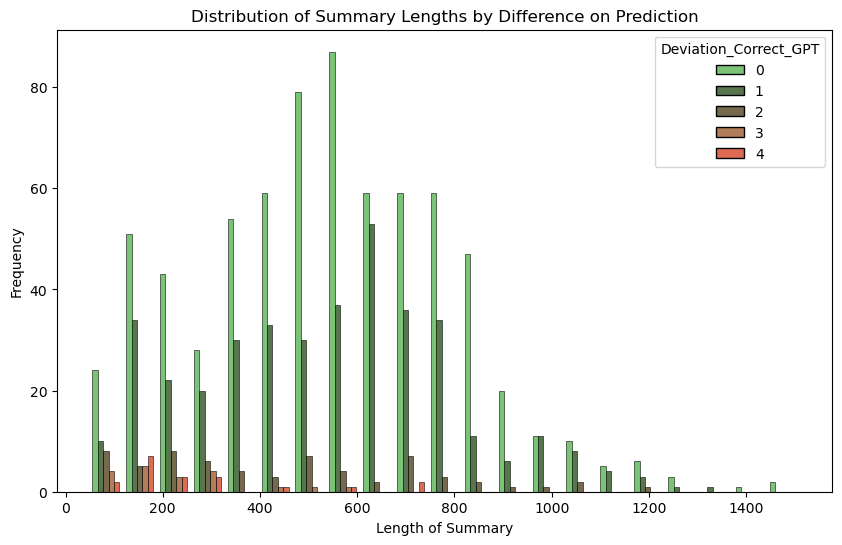

In [275]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=evaluation_dataset, x='Length_Summary', hue='Deviation_Correct_GPT', multiple='dodge', shrink=0.8,palette=custom_palette)
plt.title('Distribution of Summary Lengths by Difference on Prediction')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')

# Show the plot
plt.show()

We can see that predicts mostly correctly or deviating by 1. It seems to perform better in the strip between 350 and 900 characters.

#### Analising the unigrams and bigrams of the summaries

We have to preprocess and tokenize the summaries, and then join the tokens in order to form a text that can be vectorized

In [276]:
evaluation_dataset['Summaries_Preprocessed'] = [" ".join(text_preprocesser(summary)) for summary in evaluation_dataset['Review_Summaries'].values]

#### UNIGRAMS

In [277]:
# Compute TF-IDF for unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix = vectorizer.fit_transform(evaluation_dataset['Summaries_Preprocessed'])
feature_names = vectorizer.get_feature_names_out()

# Extract most relevant features for each rating
top_n = 10  # Number of top features to extract for each rating
rating_keywords = defaultdict(list)

for rating in evaluation_dataset['Rating'].unique():
    indices = evaluation_dataset[evaluation_dataset['Rating'] == rating].index
    
    average_tfidf = np.ravel(tfidf_matrix[indices].mean(axis=0))
    sorted_indices = average_tfidf.argsort()[::-1]
    top_features = [(feature_names[i], average_tfidf[i]) for i in sorted_indices[:top_n]]
    rating_keywords[rating].extend(top_features)

# Print the most relevant words and bigrams for each rating
for rating, features in rating_keywords.items():
    print(f"Rating {rating}:")
    for feature, score in features:
        print(f"  - {feature} (score: {score:.2f})")
    print()

Rating 5:
  - book (score: 0.11)
  - reviewer (score: 0.09)
  - positive (score: 0.06)
  - express (score: 0.05)
  - character (score: 0.05)
  - highly (score: 0.05)
  - praise (score: 0.04)
  - review (score: 0.04)
  - love (score: 0.04)
  - mention (score: 0.04)

Rating 1:
  - book (score: 0.11)
  - reviewer (score: 0.09)
  - negative (score: 0.09)
  - sentiment (score: 0.07)
  - express (score: 0.07)
  - character (score: 0.05)
  - criticize (score: 0.05)
  - lack (score: 0.04)
  - find (score: 0.04)
  - strong (score: 0.04)

Rating 3:
  - book (score: 0.11)
  - reviewer (score: 0.09)
  - find (score: 0.06)
  - character (score: 0.06)
  - mention (score: 0.05)
  - express (score: 0.05)
  - feel (score: 0.05)
  - sentiment (score: 0.04)
  - review (score: 0.03)
  - lack (score: 0.03)

Rating 4:
  - book (score: 0.10)
  - reviewer (score: 0.09)
  - positive (score: 0.06)
  - character (score: 0.04)
  - mention (score: 0.04)
  - express (score: 0.04)
  - author (score: 0.04)
  - read (

We can see that for the unigrams, the most relevant words are very similar between each class. We can see that the words positive and negative appear in both of the expected classes. Given the similarities between the words, it can make sense why the VADER classifier barely differentiates between the very positive and the positive and the very negative and negative.

#### BIGRAMS

In [278]:
vectorizer = TfidfVectorizer(ngram_range=(2,2))
tfidf_matrix = vectorizer.fit_transform(evaluation_dataset['Summaries_Preprocessed'])
feature_names = vectorizer.get_feature_names_out()

# Extract most relevant features for each rating
top_n = 10  # Number of top features to extract for each rating
rating_keywords = defaultdict(list)

for rating in evaluation_dataset['Rating'].unique():
    indices = evaluation_dataset[evaluation_dataset['Rating'] == rating].index
    
    average_tfidf = np.ravel(tfidf_matrix[indices].mean(axis=0))
    sorted_indices = average_tfidf.argsort()[::-1]
    top_features = [(feature_names[i], average_tfidf[i]) for i in sorted_indices[:top_n]]
    rating_keywords[rating].extend(top_features)

# Print the most relevant words and bigrams for each rating
for rating, features in rating_keywords.items():
    print(f"Rating {rating}:")
    for feature, score in features:
        print(f"  - {feature} (score: {score:.2f})")
    print()

Rating 5:
  - positive sentiment (score: 0.03)
  - reviewer express (score: 0.03)
  - sentiment book (score: 0.02)
  - highly recommend (score: 0.02)
  - express positive (score: 0.02)
  - recommend book (score: 0.02)
  - review reviewer (score: 0.01)
  - book describe (score: 0.01)
  - highly positive (score: 0.01)
  - book review (score: 0.01)

Rating 1:
  - negative sentiment (score: 0.05)
  - sentiment book (score: 0.04)
  - express negative (score: 0.04)
  - reviewer express (score: 0.04)
  - express strong (score: 0.02)
  - strong negative (score: 0.02)
  - book describe (score: 0.02)
  - book suggest (score: 0.01)
  - book review (score: 0.01)
  - review reviewer (score: 0.01)

Rating 3:
  - reviewer express (score: 0.02)
  - sentiment book (score: 0.02)
  - review reviewer (score: 0.02)
  - express negative (score: 0.01)
  - book review (score: 0.01)
  - negative sentiment (score: 0.01)
  - reviewer find (score: 0.01)
  - mixed feeling (score: 0.01)
  - main character (score: 0

The bigrams help differentiate a bit more between classes, and it shows that the large language model has created pretty good summaries. Nonetheless, we can see repeated bigrams between classes, so in order to improve our summaries we could take into consideration those results when making the prompt.